# Subpart 3: Quantification of Intensity on a state-wise level

Using plotly and cufflinks to get an interactive plot

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import cufflinks as cf

In [8]:
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

### Manipulating the population density here because it is a string and not a float

In [9]:
pop_density = pd.read_csv('population_india_census2011.csv')

Renaming column

In [10]:
pop_density.rename(columns = {'State / Union Territory': 'State/UnionTerritory'}, inplace= True)
pop_density = pop_density[['State/UnionTerritory', 'Density']]

Converting Density to float

In [11]:
len = pop_density['Density'].count()
len =len.item()

for i in range(len):
    text = pop_density.Density.loc[i]
    req=text[:text.find('/')]
    req = req.replace(",","")
    pop_density.Density.loc[i]=req
    

pop_density['Density']=pop_density.Density.astype(float)

Calculating Intensity with the help of confirmed cases and density

In [12]:
total_cases = pd.read_csv('covid_19_india.csv', parse_dates=['Date'], dayfirst=True,usecols=['Date', 'State/UnionTerritory','Confirmed'])
by_state = total_cases.sort_values('State/UnionTerritory')
by_state['Confirmed']=by_state.Confirmed.astype(float)
by_state=by_state.merge(pop_density)
by_state['Intensity']= by_state['Confirmed']/by_state['Density']

### Taking input from the user and displaying the change in intensity in a state over time

Taking input from the user and setting a table related to the desired state

In [13]:
state = input("Enter State ")
filt = by_state['State/UnionTerritory']== state
state_intensity= by_state[filt]
state_intensity =state_intensity.sort_values('Date', ascending =True).reset_index(drop = True)
state_intensity_subset = state_intensity[['Date', 'Intensity']]

Enter State Tamil Nadu


Plotting a bar graph showing the change in intensity over time

In [16]:
state_intensity_subset = state_intensity_subset.pivot_table(index=['Date'])
plot_title= "Intensity in "+state+" over time"
state_intensity_subset.iplot(kind = 'bar', title= plot_title)

### Plotting the Intensity on the last reported date on the map of india

Reading the csv file and calculating the intensity for the each state

In [26]:
total_cases = pd.read_csv('covid_19_india.csv',parse_dates=['Date'],dayfirst=True ,usecols=['Date','State/UnionTerritory','Confirmed'])
total_cases=total_cases.merge(pop_density)
total_cases['Confirmed']= total_cases['Confirmed']/total_cases['Density']
total_cases['Intensity']=total_cases['Confirmed']

Finding out the intensity in all the states on the last recorded day

In [27]:
total_cases['latest_date']=total_cases.groupby('State/UnionTerritory')['Date'].transform('max')
rows=total_cases.shape[0]
i=0
filt=[None]*rows
for i in range(rows):
    filt[i]=[total_cases.at[i,'Date'] == total_cases.at[i,'latest_date']]
total_cases=total_cases[filt]
total_cases=total_cases.sort_values('State/UnionTerritory', ascending =True)
total_cases= total_cases.drop(columns=['Date','Density','latest_date','Confirmed']).reset_index(drop=True)



Reading the shape file used to represent the map of India

In [19]:
fp = "Indian_States.shp"
map_df = gpd.read_file(fp)

Renaming the entry of Delhi in the shape file df to match the name in the dataset

In [20]:
map_df['st_nm']=map_df['st_nm'].replace({'NCT of Delhi':'Delhi'})
total_cases_map= map_df.set_index('st_nm').join(total_cases.set_index('State/UnionTerritory'), how ='left')

Visualisation of Intensity with the help of a bar graph

In [21]:
total_cases_state = total_cases.pivot_table(index=['State/UnionTerritory'])
total_cases_state = total_cases_state.sort_values(['Intensity'], ascending = False)
total_cases=total_cases_state.iplot(kind ='bar',title="Intensity in various states/union territories on last reported day")

Visualisation of the Intensity on the Map of India

Note: Areas like Ladakh will not appear on the map as it is not part of the shape file. White spaces indicate zero intensity

D:\conda\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning:

invalid value encountered in less



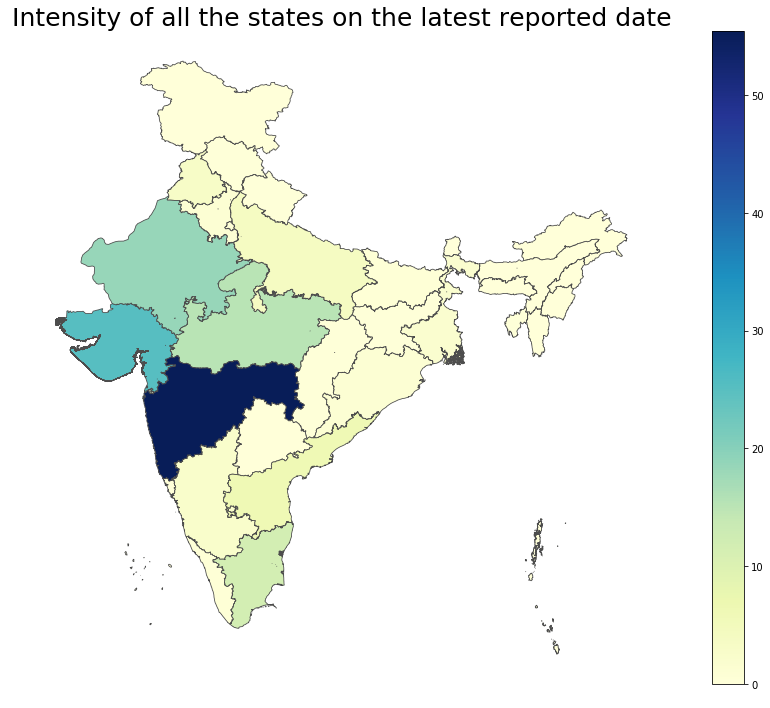

In [22]:
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Intensity of all the states on the latest reported date', fontdict={'fontsize': '25', 'fontweight' : '3'})
total_cases_map.plot(column='Intensity', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True)
fig.savefig("State_wise.png", dpi=100)